In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define paths to CSV files
train_csv_path = "/kaggle/input/fashion/fashion-mnist_train.csv"
test_csv_path = "/kaggle/input/fashion/fashion-mnist_test.csv"

# Load CSV files using pandas
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

# Print dataset shape
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")


Train dataset shape: (60000, 785)
Test dataset shape: (10000, 785)


In [10]:
class FashionMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.labels = data.iloc[:, 0].values  # First column is the label
        self.images = data.iloc[:, 1:].values  # Remaining 784 columns are pixel values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8).reshape(28, 28)  # Reshape to 28x28
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),      # Convert numpy array to PIL image
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Create datasets
train_dataset = FashionMNISTDataset(train_data, transform=transform)
test_dataset = FashionMNISTDataset(test_data, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset loaded: {len(train_dataset)} samples")
print(f"Test dataset loaded: {len(test_dataset)} samples")


Train dataset loaded: 60000 samples
Test dataset loaded: 10000 samples


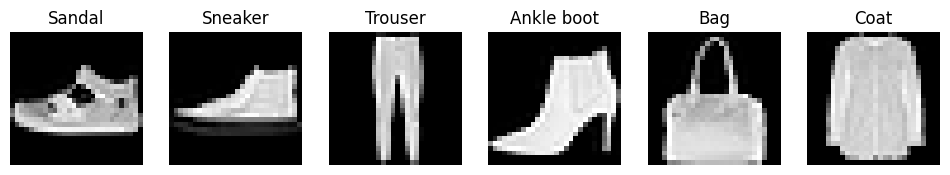

In [12]:
# Class labels for Fashion MNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display first 6 images
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(classes[labels[i].item()])
    axes[i].axis("off")
plt.show()


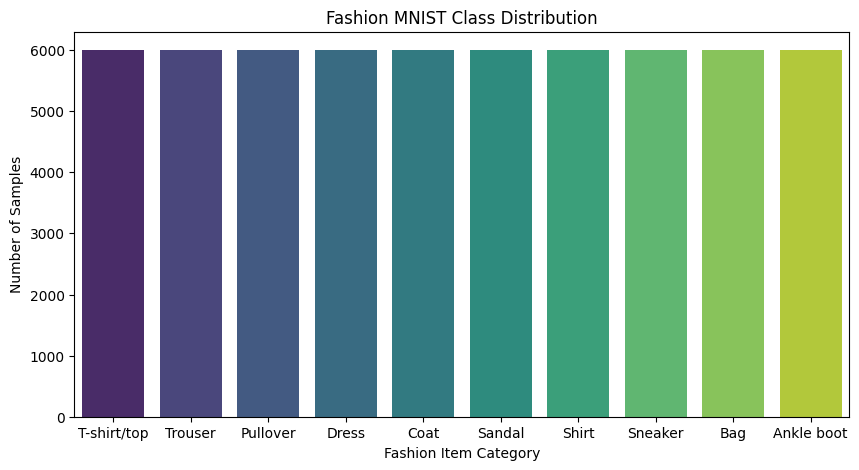

In [13]:
import seaborn as sns

# Get label counts
label_counts = train_data.iloc[:, 0].value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(ticks=range(10), labels=classes)
plt.xlabel("Fashion Item Category")
plt.ylabel("Number of Samples")
plt.title("Fashion MNIST Class Distribution")
plt.show()


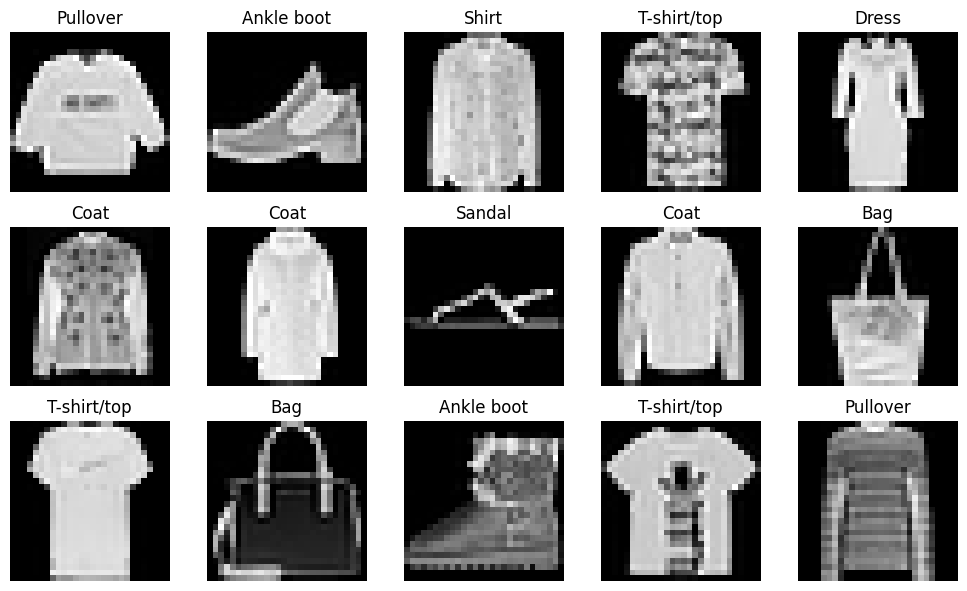

In [14]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.flatten()

for i in range(15):
    img = train_dataset[i][0].squeeze()  # Get image
    label = train_dataset[i][1]  # Get label
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(classes[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [15]:
transforms.Normalize((0.5,), (0.5,))


Normalize(mean=(0.5,), std=(0.5,))

In [16]:
import os
from PIL import Image

# Define directories
preprocessed_dir = "./data/preprocessed/"
os.makedirs(preprocessed_dir, exist_ok=True)

# Save Preprocessed Images
for idx in range(len(train_dataset)):
    image, label = train_dataset[idx]
    label_dir = os.path.join(preprocessed_dir, str(label))
    os.makedirs(label_dir, exist_ok=True)

    image_path = os.path.join(label_dir, f"{idx}.png")
    image = image.squeeze(0)  # Remove extra channel dimension
    image = Image.fromarray((image.numpy() * 255).astype("uint8"))  # Convert to image
    image.save(image_path)

print("✅ Preprocessed images saved successfully!")


✅ Preprocessed images saved successfully!


In [17]:
from torchvision import transforms

# Define augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
])

# Directory for augmented images
augmented_dir = "./data/processed_augmented/"
os.makedirs(augmented_dir, exist_ok=True)

# Apply Augmentation and Save Augmented Images
for idx in range(len(train_dataset)):
    image, label = train_dataset[idx]
    
    # Apply augmentation
    augmented_image = augmentation_transform(image)
    
    label_dir = os.path.join(augmented_dir, str(label))
    os.makedirs(label_dir, exist_ok=True)

    image_path = os.path.join(label_dir, f"aug_{idx}.png")
    augmented_image = augmented_image.squeeze(0)
    augmented_image = Image.fromarray((augmented_image.numpy() * 255).astype("uint8"))
    augmented_image.save(image_path)

print("✅ Augmented images saved successfully!")


✅ Augmented images saved successfully!


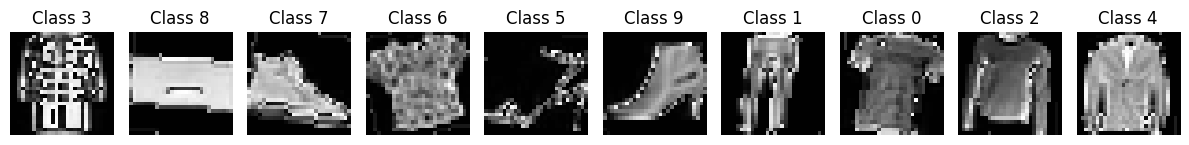

In [18]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Define the directory where augmented images are stored
augmented_dir = "./data/processed_augmented/"

# Get a random sample of augmented images from different classes
num_samples = 6  # Number of images to display
sample_images = []

# Ensure the directory exists before trying to access files
if os.path.exists(augmented_dir):
    for class_label in os.listdir(augmented_dir):
        class_path = os.path.join(augmented_dir, class_label)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            if image_files:
                random_image = random.choice(image_files)
                sample_images.append(os.path.join(class_path, random_image))

# Display the selected augmented images
fig, axes = plt.subplots(1, len(sample_images), figsize=(12, 3))
for i, image_path in enumerate(sample_images):
    img = Image.open(image_path)
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Class {os.path.basename(os.path.dirname(image_path))}")

plt.tight_layout()
plt.show()


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import numpy as np

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Conv layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(128, 10)  # Output layer (10 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


In [20]:
class AugmentedFashionMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for image_file in os.listdir(label_dir):
                    self.image_paths.append(os.path.join(label_dir, image_file))
                    self.labels.append(int(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_dataset = AugmentedFashionMNIST(root_dir="./data/processed_augmented/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print(f"Loaded {len(train_dataset)} augmented images for training.")


Loaded 60000 augmented images for training.


In [22]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.8897
Epoch [2/10], Loss: 0.6413
Epoch [3/10], Loss: 0.5570
Epoch [4/10], Loss: 0.5054
Epoch [5/10], Loss: 0.4686
Epoch [6/10], Loss: 0.4392
Epoch [7/10], Loss: 0.4148
Epoch [8/10], Loss: 0.3894
Epoch [9/10], Loss: 0.3682
Epoch [10/10], Loss: 0.3471


In [23]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Training Accuracy: {accuracy:.2f}%")


Training Accuracy: 90.75%


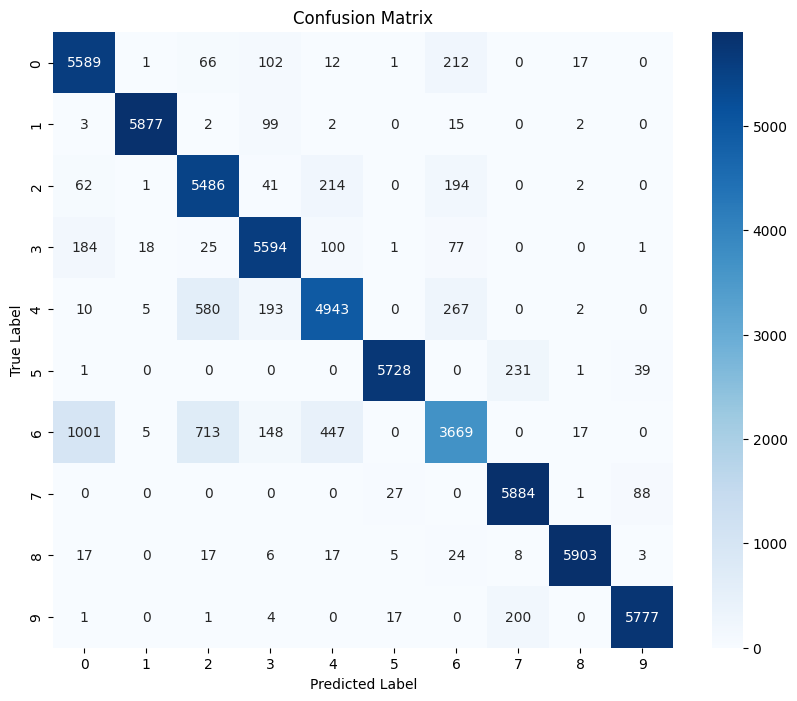

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for the dataset
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [25]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8138    0.9315    0.8687      6000
           1     0.9949    0.9795    0.9872      6000
           2     0.7962    0.9143    0.8512      6000
           3     0.9042    0.9323    0.9180      6000
           4     0.8619    0.8238    0.8424      6000
           5     0.9912    0.9547    0.9726      6000
           6     0.8230    0.6115    0.7017      6000
           7     0.9306    0.9807    0.9550      6000
           8     0.9929    0.9838    0.9884      6000
           9     0.9778    0.9628    0.9703      6000

    accuracy                         0.9075     60000
   macro avg     0.9086    0.9075    0.9055     60000
weighted avg     0.9086    0.9075    0.9055     60000



In [26]:
loss_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_values.append(total_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.3349
Epoch [2/10], Loss: 0.3167
Epoch [3/10], Loss: 0.3027
Epoch [4/10], Loss: 0.2876
Epoch [5/10], Loss: 0.2729
Epoch [6/10], Loss: 0.2604
Epoch [7/10], Loss: 0.2477
Epoch [8/10], Loss: 0.2411
Epoch [9/10], Loss: 0.2261
Epoch [10/10], Loss: 0.2199
